## Formant Statistics and The Formant Triangle
+ ###### Author: Dirk Van Compernolle   
+ ###### Modification History:   1/1/2020, 25/04/2022, 11/02/2023
+ ###### Requires:  pyspch>=0.7


#### Background and Motivation
The main purpose of this demo notebook is to explore formant statistics.
Since the experiments of Peterson and Barney in the early 1950's we know that formants
carry great discriminative power for the recognition of vowels.

In the early days of speech recognition formant extraction followed by formant based recognition 
was considered one of the ways to go.  This is long obsolete by now.
Formants are too ill-defined and as a feature set it is too minimal.   
At the same time formants are robust against all kinds of signal manipulations and are
illustrative for the tremendous redundancy present in speech
(from a recognition point of view) .   

In this notebook we focus on the 'explorative phase' in which we explore the potential of formants for speech recognition.

The goal is to observe both WITHIN and BETWEEN class differences.   Also observe that there are significant side factors entering into this recognition game: gender, age, .. 

In [14]:
# uncomment the pip install command to install pyspch -- it is required!
#
#!pip install git+https://github.com/compi1234/pyspch.git
#
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [15]:
# Importing some core Python libraries for data handling and plotting's baseline machine learning stack 
#
%matplotlib inline
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns

import pyspch.core as Spch
from pyspch.core.hillenbrand import fetch_hillenbrand, select_hillenbrand
#
np.set_printoptions(precision=2)
mpl.rcParams['figure.figsize'] = [8.0, 8.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'

## The Hillenbrand Database 
All demonstrations in this notebook are using (parts of) the Hillenbrand '95 database. For detailed information and references: http://homes.esat.kuleuven.be/~spchlab/data/hillenbrand/README.txt

The function *fetch_hillenbrand()* fetches the Hillenbrand database or part of it. By default it returns the most used columns.
Possible subselection criteria for rows are genders="..." and vowels="...". Columns are selected with the columns arguments. 

To get more details on this routine, type help(fetch_hillenbrand)

The fetch_hillenbrand() returns a pandas dataframe.   This is a basic 2-dimensional datastructure.  The rows are data records; these may be labeled by an index; in the example below the index is the file-id.  The columns are labeled data fields.  As called, the routine returns gender, vowel, f0, F1, F2 and F3.  The first 2 are label (class) properties.  The latter 4 are numeric values.
We drop all records with missing data values in the requested fields.

### Hillenbrand vs. Peterson-Barney
The Hillenbrand dataset is mostly a recreation of the famous Peterson-Barney dataset that, however, was never available in digital format.  So it serves the same purpose.  A few remarkable facts however:
- Hillenbrand uses 12 instead of 10 vowels.  However the extra vowels ('ey'('ei') and 'ow'('oa') are diphtongs rather than steady state vowels) and not truly suitable for steady state analysis.  We omit those 2 diphtongs in the analysis here.
- The 'mean' values in the Hillenbrand database deviate significantly from what was reported by Peterson and Barney, indicating a linguistic shift

In this notebook we convert the Hillebrand notations to more standard ARPABET notation.

In [16]:
hildata = fetch_hillenbrand(symbols='arpa').dropna()
all_vowels = np.unique(hildata['vowel'])
all_genders = np.unique(hildata['gender'])
all_features = ["f0","F1","F2","F3"]
print(all_vowels)
print(all_genders)
print(all_features)
#
hildata

['aa' 'ae' 'ah' 'ao' 'eh' 'er' 'ey' 'ih' 'iy' 'ow' 'uh' 'uw']
['b' 'g' 'm' 'w']
['f0', 'F1', 'F2', 'F3']


,gender,vowel,f0,F1,F2,F3
fid,,,,,,
m01ae,m,ae,174,663,2012,2659
m02ae,m,ae,102,628,1871,2477
m03ae,m,ae,99,605,1812,2570
m04ae,m,ae,124,627,1910,2488
m06ae,m,ae,115,647,1864,2561
...,...,...,...,...,...,...
g17uw,g,uw,236,490,2179,3131
g18uw,g,uw,214,435,1829,3316
g19uw,g,uw,243,497,1334,3067


In [17]:
# create some handly lists and dictionaries to have consistent color coding throughout all plots
# some default graphical settings 
# including colorpalette and markers that can handle 12 class data 
markers = ('o', 'P','v', '^', '<', '>', 'X','8', 's', '*', 'h', 'H', 'D', 'd', 'P','p')
colors = [ 'b','g','r','magenta','teal','gold','darkorange','navy','grey','maroon',
               'lightblue','darkkhaki']
cmap = sns.color_palette(colors)
sns.set_palette(cmap)
#sns.palplot(cmap)
#
table_order = ['iy','ih','eh','ae','aa','ao','uh','uw','ah','er','ey','ow']
vowel_order = ['iy','aa','uw','ih','eh','er','ah','ae','ao','uh','ey','ow']
vowel2color = dict(zip(vowel_order,colors))
color2vowel = dict(zip(colors,vowel_order))
vow12 = vowel_order
vow10 = vowel_order[0:10]
vow3 = vowel_order[0:3]
vow6 = vowel_order[0:6]

## Exploring with Scatter Plots of F1-F2 vowel data

The scatter plots below are shown for 3, 6, respectively 10 classes (the vowel classes used by Peterson & Barney, 1952).
While the 3 classes are perfectly separable in the F1-F2 space, this is only partially true for the 6 classes and not at all for the 10 class data.

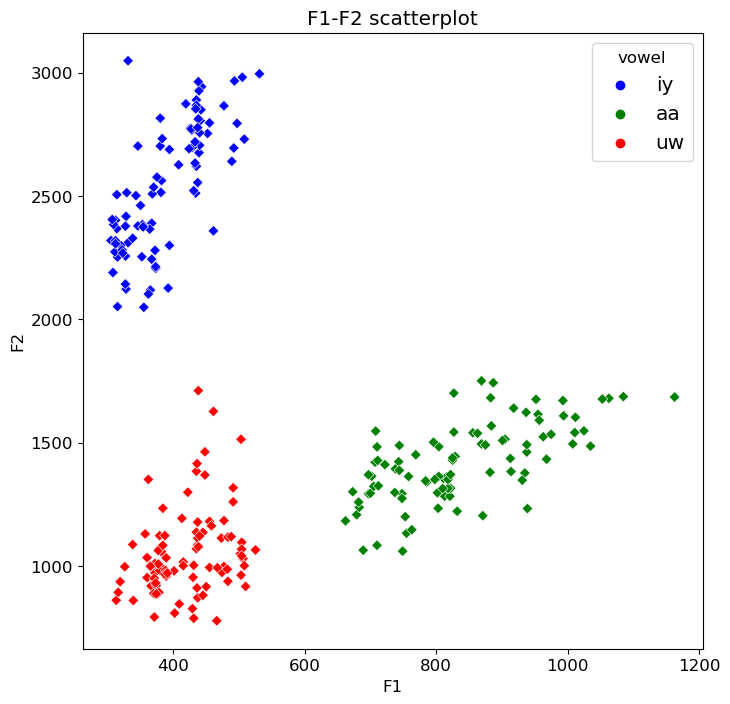

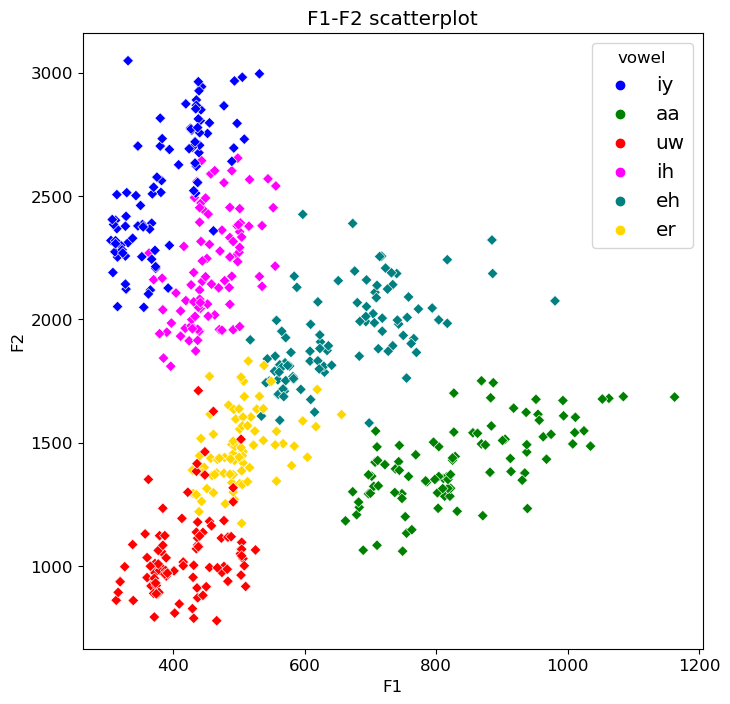

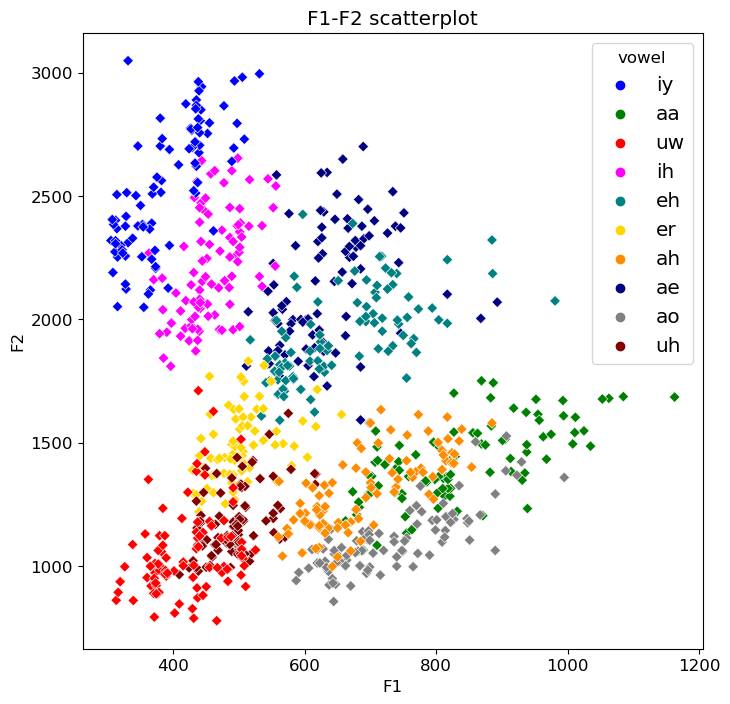

In [18]:
genders = 'adults'
# select the vowels you want to plot
for vow in [vow3,vow6,vow10]:
    f,ax = plt.subplots()
    df = select_hillenbrand(hildata,genders=genders,vowels=vow)
    sns.scatterplot(ax=ax,x='F1',y='F2',data=df,hue="vowel",marker='D',s=30,hue_order=vow)
    ax.set_title('F1-F2 scatterplot');

## Alternative plotting style with labels printed at each data point
The above scatter plots can also be shown in a variant where the datapoints are marked with their own label

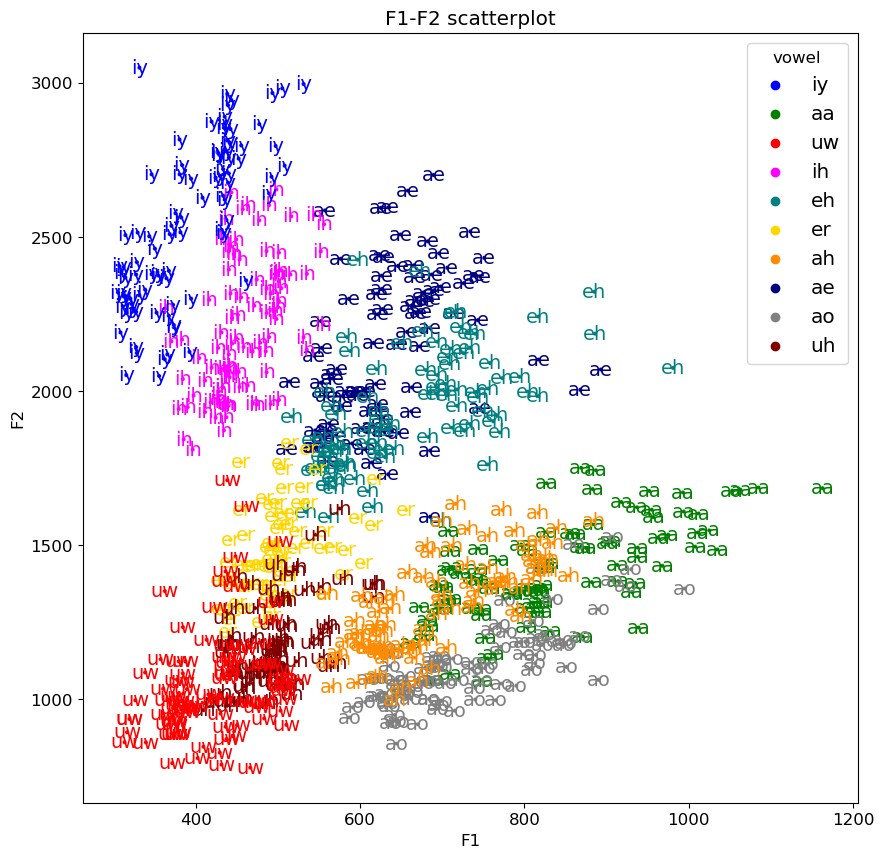

In [19]:
ftr = ['F1','F2']
for vowels in [vow10]:
    f,ax = plt.subplots(figsize=(10,10))
    df = select_hillenbrand(hildata,genders=genders,vowels=vowels)
    sns.scatterplot(x=ftr[0],y=ftr[1],data=df,hue="vowel",s=10,hue_order=vowels);
    for i,entry in df.iterrows():
        vow = entry['vowel']
        plt.text(entry[ftr[0]],entry[ftr[1]],vow,ha='center',va='center',fontsize=14,color=vowel2color[vow] )
        ax.set_title('F1-F2 scatterplot');

## How separable are the data ?
When we make a simple gaussian fit to the bivariate distributions, we can have a guess of how separable
the different distributions are.   
In the plots below we show contours at 2xsigma

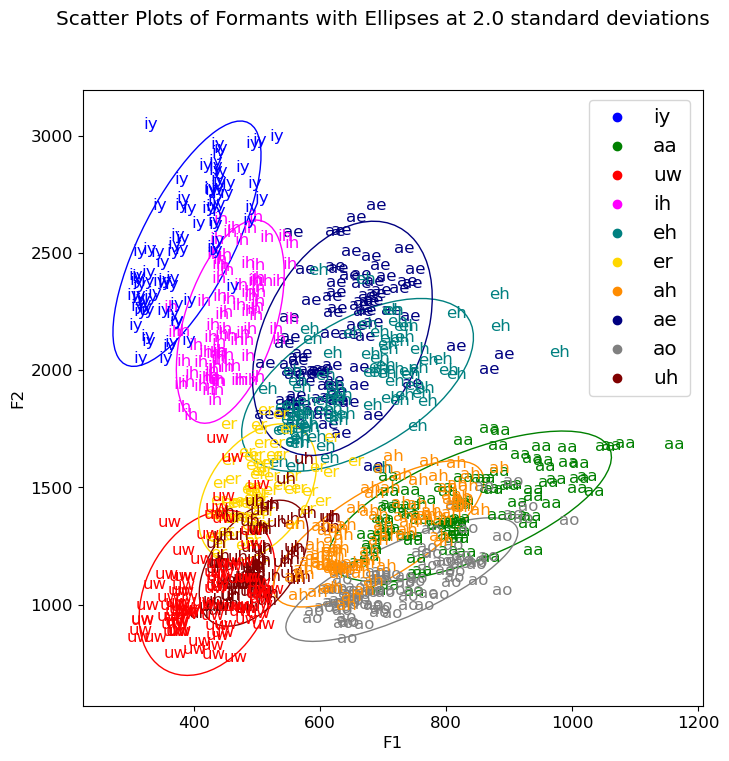

In [20]:
marker_txt = ('a','b')
genders = ['m','w']
(xfeat,yfeat) = ['F1','F2']
vowels = vow10
n_std = 2.

data = select_hillenbrand(hildata,genders=genders,vowels=vowels)

# setup the scatterplot and legend
fig,ax=plt.subplots(figsize=(8,8))
sns.scatterplot(x=xfeat,y=yfeat,data=data,hue='vowel',cmap=cmap,hue_order=vowels,s=0)

# plot the datapoints as text
for i,entry in data.iterrows():
    vow = entry['vowel']
    ax.text(entry[xfeat],entry[yfeat],vow,ha='center',va='center',color=vowel2color[vow] )
    
for vow in vowels:
    vowdata = select_hillenbrand(hildata,genders=genders,vowels=[vow])
    Spch.plot_confidence_ellipse(vowdata[xfeat], vowdata[yfeat], ax, n_std=n_std, edgecolor=vowel2color[vow] )
    
#sns.scatterplot(ax=f.axes[0],data=formants,x='F1',y='F2',hue='vowel',style='gender',s=2000)
ax.legend(loc='upper left', bbox_to_anchor=(0.8,1));
fig.suptitle("Scatter Plots of Formants with Ellipses at %.1f standard deviations" % n_std);

## Formant Triangle
First we compute the mean values for the different formants.   
We do this for both global means and means per gender.   
The table below shows formant values per gender.  

#### Observations and Questions
+ determine (very roughly) the average differences between male and female formants 
    - what would you say:  less than 10%, 10-15%, 15-20%, more than 20%
+ what is the physical explanation in this gender dependency of the formants: what is true ?
    - this is related to the average weight difference between male and female
    - this is the exact percentage that men are taller than woman 
    - this is directly related to the difference in vocal tract length

In [21]:
pd.options.display.float_format = '     {:.0f}  '.format
fdata = select_hillenbrand(hildata,genders='adults',vowels=vow10)[['gender','vowel','F1','F2','F3']]
# average formants for all speakers
formants_all = fdata.groupby(by=["vowel"]).mean()
# average formants per gender
formants = fdata.groupby(by=["vowel","gender"]).mean()
formant_table = formants.unstack()
formant_table.transpose()[table_order[0:10]]

vowel              iy          ih          eh          ae          aa  \
   gender                                                               
F1 m            340         429         588         591         756     
   w            435         484         727         678         916     
F2 m           2312        2034        1803        1930        1309     
   w           2756        2369        2063        2332        1526     
F3 m           3001        2687        2604        2595        2535     
   w           3373        3057        2953        2973        2823     

vowel              ao          uh          uw          ah          er  
   gender                                                              
F1 m            656         469         380         621         476    
   w            801         519         460         760         527    
F2 m           1023        1123         992        1181        1370    
   w           1188        1229        1106        1416        1589    
F3 m           2521        2435        2355        2548        1711    
   w           2819        2829        2735        2901        1930

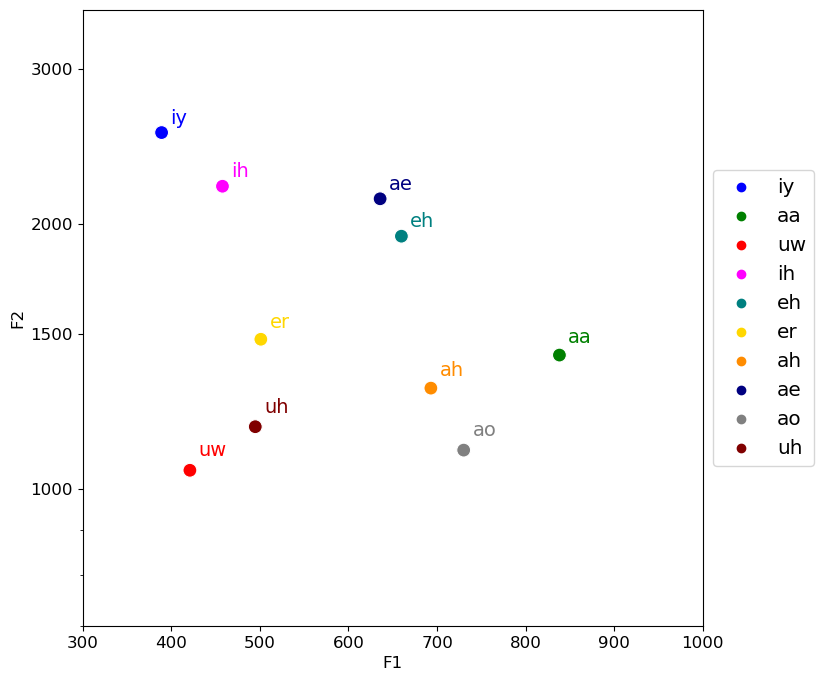

In [22]:
vowels = vow10
data = formants_all
fig,ax=plt.subplots(figsize=(8,8))
g = sns.scatterplot(data=data,x='F1',y='F2',hue='vowel',hue_order=vowels,s=100)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim([300,1000])
ax.set_ylim([700,3500])
ax.set_yscale('log')
ax.set_yticks([1000.,1500,2000.,3000.])
ax.set_yticklabels(['1000','1500','2000','3000']);
for vow in vowels:
    F1 = data['F1'][vow]
    F2 = data['F2'][vow]
    ax.text(F1+10,F2+30,vow,ha='left',va='bottom',fontsize=14,color=vowel2color[vow] )    

## Formant Triangle
Thte "Formant Triangle" refers to the fact that the average positions of all vowels in the F1-F2 plane
are situated on a triangle with as edge points iy, aa and uw.   
Remark also that there is one vowel ('er') that doesn't fit the above at all as it is situated in the center of the triangle.


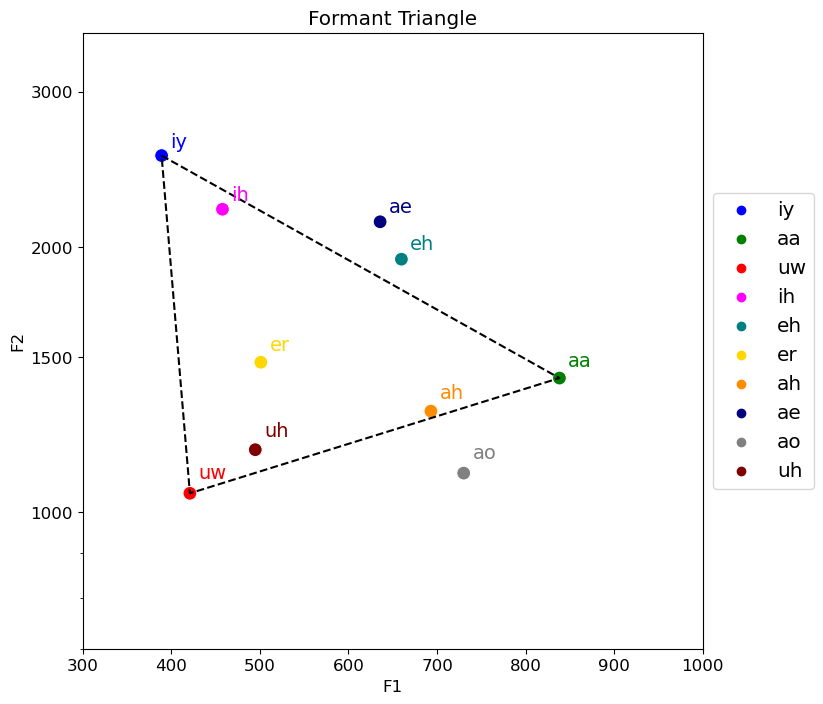

In [23]:
f1_vals = [ data['F1'][v] for v in ['iy','aa','uw'] ]
f2_vals = [ data['F2'][v] for v in ['iy','aa','uw'] ]
ax.plot([f1_vals[k] for k in [0,1,2,0]],[f2_vals[k] for k in [0,1,2,0]],color='k',linestyle='dashed')
ax.set_title('Formant Triangle')
fig

## Gender Dependency of formants

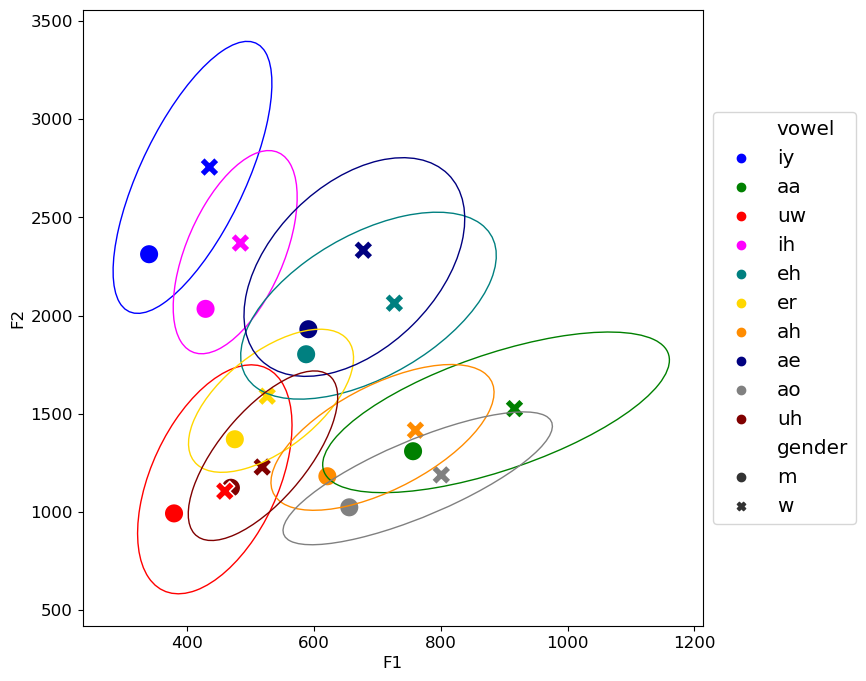

In [24]:
vowels = vow10
data = formants
f=plt.figure(figsize=(8,8))
g = sns.scatterplot(data=data,x='F1',y='F2',hue='vowel',hue_order=vowels,style='gender',s=200)
f.axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
for vow in vowels:
    vowdata = select_hillenbrand(hildata,vowels=[vow])
    Spch.plot_confidence_ellipse(vowdata[xfeat], vowdata[yfeat], f.axes[0], n_std=2, edgecolor=vowel2color[vow])

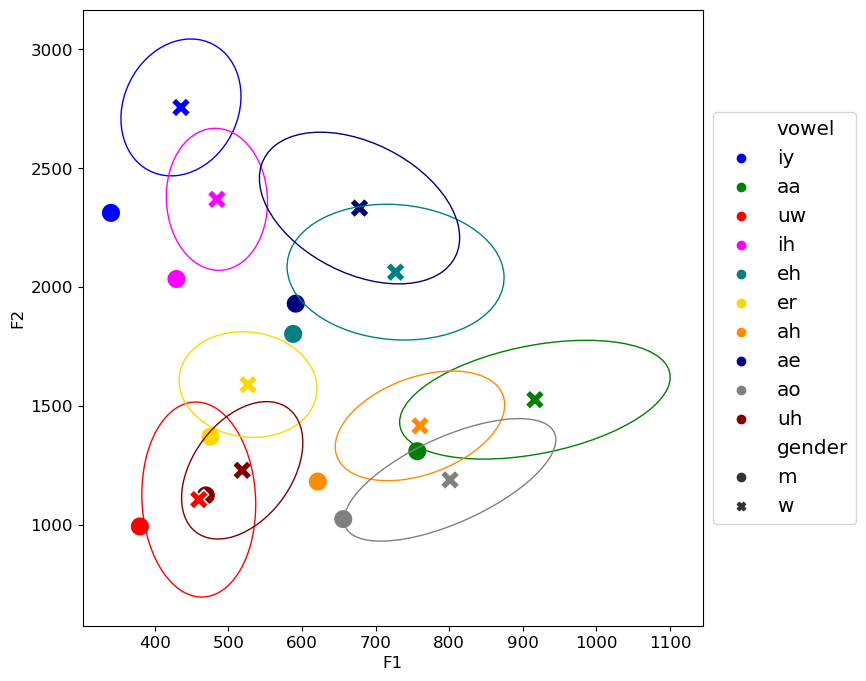

In [25]:
# only for male or female data
vowels = vow10
data = formants
gender = ['w']
f=plt.figure(figsize=(8,8))
g = sns.scatterplot(data=data,x='F1',y='F2',hue='vowel',hue_order=vowels,style='gender',s=200)
f.axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
for vow in vowels:
    vowdata = select_hillenbrand(hildata,vowels=[vow],genders=gender)
    Spch.plot_confidence_ellipse(vowdata[xfeat], vowdata[yfeat], f.axes[0], n_std=2, edgecolor=vowel2color[vow])

(250.0, 1200.0)

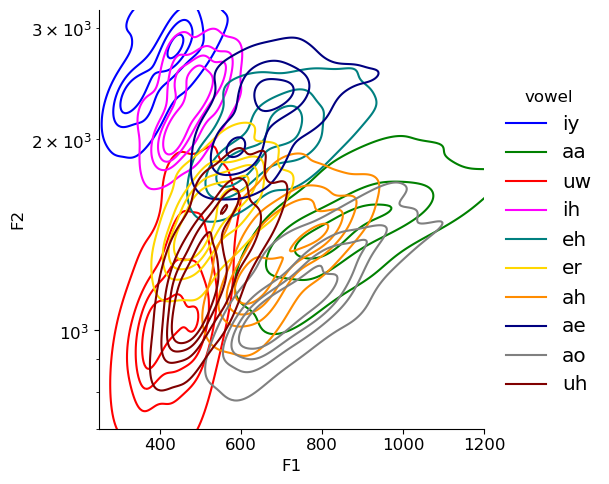

In [26]:
# showing with kernel density plots
data = select_hillenbrand(hildata,vowels=vow10)
sns.displot(data, x="F1", y="F2", hue="vowel", kind="kde",hue_order=vow10,levels=5,bw_adjust=1)
plt.yscale('log')
plt.ylim([700.,3200.])
plt.xlim([250.,1200.])

## Beyond F1-F2 as features: Grid plots for higher dimensional data

Finally we add 'f0' and 'F3' to our observations.
In this case we cannot display the data distribution in a single scatterplot, but need to look at a multitude of 2D scatter plots.
It is quite obvious that extra information may be obtained from F3 and f0.
- f0 correlates always to a bimodal distribution
- F3 is in a few cases very distinctive, e.g. for /er/, which is not well distinguished with F1,F2 alone

<Figure size 1000x1000 with 0 Axes>

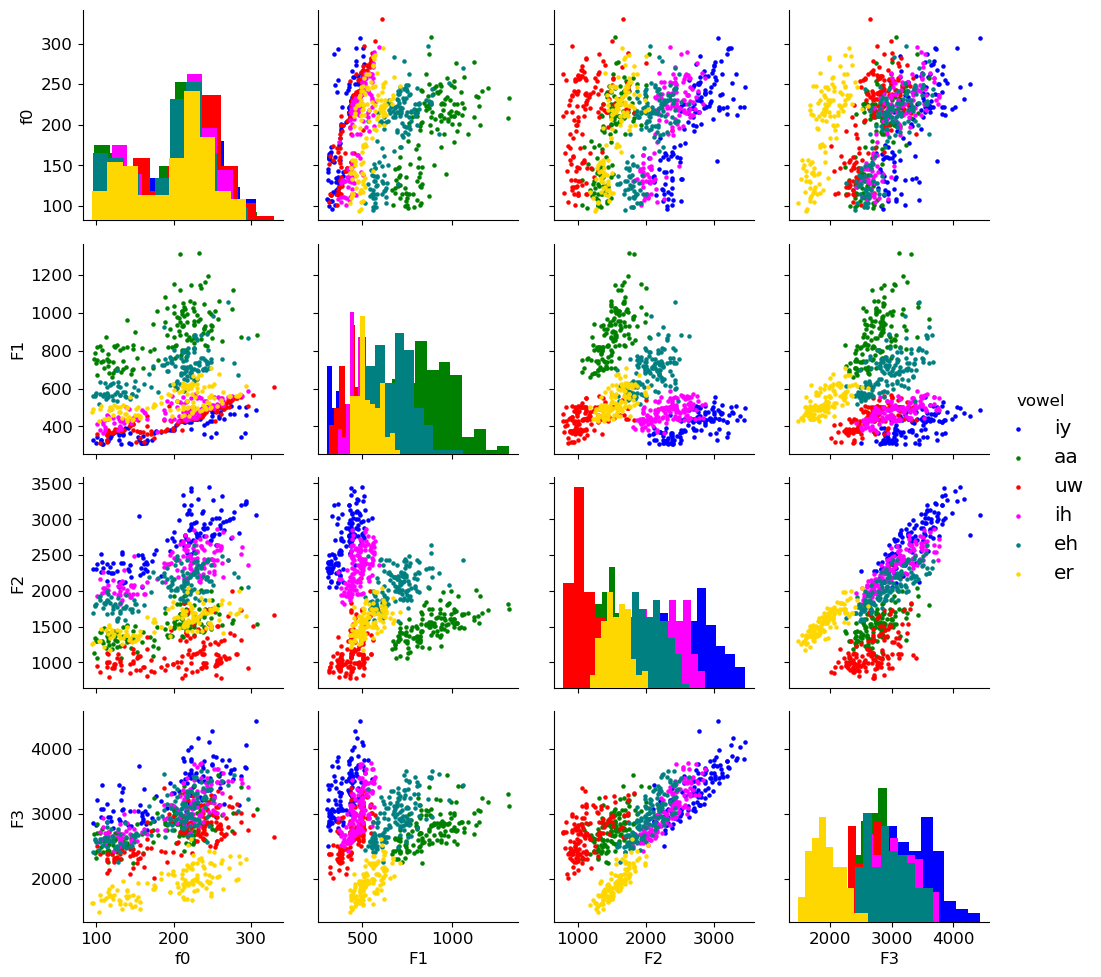

In [14]:
genders = ['m','w']
nvow = 6
features = ['f0','F1','F2','F3']
# select data and set classes / side_kick
data =select_hillenbrand(hildata,vowels=vow6)
target = 'vowel'
classes = vow6
side_classes = genders


##########################
# 1. make a grid plot using all features and the target as hue 
f=plt.figure(figsize=(10,10))
g = sns.PairGrid(data.loc[:,[target]+features],hue=target,hue_order=classes)
g.map_diag(plt.hist, linewidth=1)
g.map_offdiag(plt.scatter,s=5)
g.add_legend()
#